#  Reparameterisation trick: simple demonstration

In this notebook we will implement the reparameterisation trick in a simple example.

---

TL;DR: The reparam trick allows us to backpropagate through stochastic nodes in a network. It also creates an estimator for the gradient-of-an-expectation-value which often has less variance than one created using the log-likelihood trick alone. We achieve this by moving the parameter dependence inside of the function being averaged. In general the MC samples for this estimator have more consistent weights, reducing the variance on the average. In the "original" method, datapoints are given MC weights of $f\left(x\right)\nabla_\theta \log p_\theta\left(x\right)$, whereas in the reparameterised method they are $f\left(\epsilon,\theta\right)\nabla_\theta\log f\left(\epsilon,\theta\right)$. In the first case, unlikely datapoints necessarily pick up large weights, whereas in the second method, the weights depend on the behaviour of the function. The estimator is efficient when $f$ is relatively independent of $\theta$ in regions where $p_\theta\left(\epsilon\right)$ is large.

---

The reparam trick is used when we want to create an unbiased estimator for the gradient of an expectation value. Typically we find two relevant cases:
1. When we perform a stochastic sampling step half way through a network. We can only backpropagate back to the input parameters when we separate the input parameters and the sampling noise.
2. When we want to numerically estimate the _gradient of an expectation value_. By using the reparam trick, we create a new estimator for the gradient. This new estimator has smaller variance than the original, because we do not assign high sampling weights to very unlikely datapoints. We are performing a type of importance sampling, since we are trying to sample important datapoints more often.

For (2), we can do this without the reparam trick by sampling over the $x$ provided as argument to the function, then average the gradient of the function for every sample. However, many of our $x$ may be sampled at points which contibute very little gradient. Since we are sampling from the data distribution and not from the optimal importance distribution of what we want to estimate (the gradient), our sampling is inefficient and may lead to high variance on our gradient estimates.

By reparameterising, we effectively write a different estimator with a sampling distribution which more closely matches the distribution being estimated. This means that the variance on the gradient estimate can be reduced.

Note however that we do not use the optimal sampling distribution, which in general we do not have access to.

---

I define some distribution $q_\theta\left(x\right)$ over $x \in \mathcal{X}$ which has parameters $\theta \in \mathcal{\Theta}$. This distribution has the form
\begin{equation}
q_\theta\left(x\right) ~=~ \mathcal{N}\left(x; \theta_0, \theta_1\right)
\end{equation}

I have a function $f\left(x\right) ~=~ 1 - x + \frac{1}{2} x^2 + \frac{1}{6} x^3$. I choose an initial value of $\theta=0$ and want to numerically iterate towards a value of $\theta$ such that
\begin{equation}
\theta \rightarrow \mathrm{argmin}_\theta ~ \mathbb{E}_{q_\theta}\left[f\left(x\right)\right]
\end{equation}

###  Method 1

To do this we will perform stochastic gradient descent
\begin{equation}
\theta \rightarrow\theta ~-~ \lambda ~ \nabla_\theta \mathbb{E}_{q_\theta}\left[f\left(x\right)\right]
\end{equation}
where we apply the log-likelihood trick to obtain
\begin{split}
\nabla_\theta \mathbb{E}_{q_\theta}\left[f\left(x\right)\right] ~&=~ \mathbb{E}_{q_\theta}\left[f\left(x\right) \nabla_\theta \log q_\theta\left(x\right)\right] \\
&=~ \mathbb{E}_{q_\theta} \begin{bmatrix} f\left(x\right) \frac{\left(x-\theta_0\right)}{\theta_1^2} , f\left(x\right) \frac{\left(x-\theta_0\right)^2}{\theta_1^3}\end{bmatrix} \\
\end{split}
which can be estimated numerically by sampling $x \sim q_\theta\left(x\right)$.

Note that this equation contains a factor of $\nabla_\theta \log q_\theta\left(x\right)$ which is very _large_ when $q_\theta\left(x\right)$ is _small_. This means that very rare datapoints may often contribute very highly to the gradient estimate (depending also on the value of $f\left(x\right)$). This makes this estimator very inefficient - ideally our most common datapoints will be those which contribute the most.

### Method 2

Alternatively, we can reparameterise the problem by decoupling the parameters $\theta$ from the stochastic distribution. Now we sample $\epsilon \sim p\left(\epsilon\right)$ with
\begin{equation}
p\left(\epsilon\right) = \mathcal{N}\left(\epsilon;0,1\right)
\end{equation}
and write $x = \theta_0 + \theta_1 \cdot \epsilon$. We now want to optimise such that
\begin{equation}
\theta \rightarrow \mathrm{argmin}_\theta ~ \mathbb{E}_{p}\left[f\left(\theta_0 + \theta_1 \cdot \epsilon\right)\right]
\end{equation}
by performing stochastic gradient descent
\begin{equation}
\theta \rightarrow\theta ~-~ \lambda ~ \nabla_\theta \mathbb{E}_{p}\left[f\left(\theta_0 + \theta_1 \cdot \epsilon\right)\right]
\end{equation}
where
\begin{split}
\nabla_\theta \mathbb{E}_{p}\left[f\left(\epsilon,\theta\right)\right] ~&=~ \mathbb{E}_{p}\left[f\left(\epsilon,\theta\right) \nabla_\theta \log f\left(\epsilon,\theta\right) \right] \\
~&=~ \mathbb{E}_{p}\begin{bmatrix} 1 + \theta_0 + \theta_1\epsilon + \frac{1}{2}\left(\theta_0 + \theta_1\epsilon\right)^2 , -\epsilon + \epsilon\left(\theta_0+\theta_1\epsilon\right) + \frac{\epsilon}{2}\left(\theta_0 + \theta_1\epsilon\right)^2 \end{bmatrix} \\
\end{split}
which can be estimated numerically by sampling $\epsilon \sim p\left(\epsilon\right)$.

Since we have removed the factors of $\log q$ from the estimator, it is more efficient.

---

N.B. for our choice of $f\left(x\right)$, it is pretty easy to evaluate these expectation values analytically. However, in general we will not know the form of $f\left(x\right)$ and we can only numerically evaluate it's value and gradient (through backpropagation).

---

**N.B. The estimators would be maximally efficient if we could importance sample from a distribution proportional to $|\nabla_\theta f\left(\epsilon,\theta\cdot\epsilon\right) \cdot p\left(\epsilon\right)|$. However, in general this will not be possible.**

In [8]:
#  Required imports

import numpy as np
from   matplotlib import pyplot as plt
from   scipy      import stats

In [2]:
#  Implement the equations listed above

f  = lambda x : 1 - x + x*x/2. + x*x*x/6.

def df_depsilon (e, theta0, theta1) :
    x = theta0 + theta1*e
    y = [-1 + theta0 + theta1*e + 0.5*x*x, -e + e*x + 0.5*e*x*x]
    return np.array(y).transpose()

def method1 (x, theta0, theta1) :
    return np.array([f(x)*(x-theta0)/theta1/theta1, f(x)*(-1./theta1 + (x-theta0)*(x-theta0)/theta1/theta1/theta1)]).transpose()

def method2 (e, theta0, theta1) :
    return df_depsilon (e, theta0, theta1)
    

In [3]:
#  Define function to plot the gradient estimates

def plot_grad_estimates(theta0, theta1, N, theta_grad_estimates_method0, theta_grad_estimates_method1) :

    fig = plt.figure(figsize=(9, 4))

    ax = fig.add_subplot(1, 2, 1)
    vals1, _, _ = ax.hist(theta_grad_estimates_method0[:,0], bins=25, density=True, color="r", alpha=0.5)
    vals2, _, _ = ax.hist(theta_grad_estimates_method1[:,0], bins=25, density=True, color="b", alpha=0.5)
    ax.text(0.95, 0.95, f"$\mu = {np.mean(theta_grad_estimates_method0[:,0]):.2f}$,  $\sigma = {np.std(theta_grad_estimates_method0[:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12, c="r")
    ax.text(0.95, 0.87, f"$\mu = {np.mean(theta_grad_estimates_method1[:,0]):.2f}$,  $\sigma = {np.std(theta_grad_estimates_method1[:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12, c="b")
    ax.set_xlabel(r"$\nabla_{\theta_0}\mathcal{L}$", fontsize=14, labelpad=15)
    ax.set_ylabel("Density", fontsize=14, labelpad=15)
    ax.text(0.05, 0.95, f"$N={N}$", transform = ax.transAxes, ha="left", va="top", fontsize=12, c="k")
    ax.text(0.05, 0.87, r"$\theta_0"+f"={theta0:.2f}$", transform = ax.transAxes, ha="left", va="top", fontsize=12, c="k")
    ax.set_ylim([0, 1.3*np.max([vals1, vals2])])
    
    ax = fig.add_subplot(1, 2, 2)
    vals1, _, _ = ax.hist(theta_grad_estimates_method0[:,1], bins=25, density=True, color="r", alpha=0.5, label=r"$x \sim q_\theta\left(x\right)$")
    vals2, _, _ = ax.hist(theta_grad_estimates_method1[:,1], bins=25, density=True, color="b", alpha=0.5, label=r"$\epsilon \sim p\left(\epsilon\right)$")
    ax.text(0.95, 0.95, f"$\mu = {np.mean(theta_grad_estimates_method0[:,1]):.2f}$,  $\sigma = {np.std(theta_grad_estimates_method0[:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12, c="r")
    ax.text(0.95, 0.87, f"$\mu = {np.mean(theta_grad_estimates_method1[:,1]):.2f}$,  $\sigma = {np.std(theta_grad_estimates_method1[:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12, c="b")
    ax.set_xlabel(r"$\nabla_{\theta_1}\mathcal{L}$", fontsize=14, labelpad=15)
    ax.text(0.05, 0.95, f"$N={N}$", transform = ax.transAxes, ha="left", va="top", fontsize=12, c="k")
    ax.text(0.05, 0.87, r"$\theta_1"+f"={theta1:.2f}$", transform = ax.transAxes, ha="left", va="top", fontsize=12, c="k")
    ax.set_ylim([0, 1.35*np.max([vals1, vals2])])
    ax.legend(loc=(0.5, 0.55), frameon=False, fontsize=12)

    plt.show()

In [4]:
#  Define function to plot the contributions to the gradient estimates

def plot_grad_estimate_scatter(theta0, theta1, N, u, x, grad_estimates_method0, grad_estimates_method1) :
    
    nbins = 25
    grad_theta_0_bins = np.linspace(np.min([grad_estimates_method0[:,0], grad_estimates_method1[:,0]]), np.max([grad_estimates_method0[:,0], grad_estimates_method1[:,0]]), 1+nbins)
    grad_theta_1_bins = np.linspace(np.min([grad_estimates_method0[:,1], grad_estimates_method1[:,1]]), np.max([grad_estimates_method0[:,1], grad_estimates_method1[:,1]]), 1+nbins)
    
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(2, 2, 1)
    ax.hist(np.fabs(grad_estimates_method0[:,0]), bins=nbins, density=True)
    ax.text(0.95, 0.95, f"$\mu = {np.mean(grad_estimates_method0  [:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.text(0.95, 0.87, f"$\sigma = {np.std(grad_estimates_method0[:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.set_ylabel(r"Density (method1)", fontsize=14, labelpad=15)
    ax.set_yscale("log")
    
    ax = fig.add_subplot(2, 2, 2)
    ax.hist(np.fabs(grad_estimates_method0[:,1]), bins=nbins, density=True)
    ax.text(0.95, 0.95, f"$\mu = {np.mean(grad_estimates_method0  [:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.text(0.95, 0.87, f"$\sigma = {np.std(grad_estimates_method0[:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.set_yscale("log")
    
    ax = fig.add_subplot(2, 2, 3)
    ax.hist(np.fabs(grad_estimates_method1[:,0]), bins=nbins, density=True)
    ax.text(0.95, 0.95, f"$\mu = {np.mean(grad_estimates_method1  [:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.text(0.95, 0.87, f"$\sigma = {np.std(grad_estimates_method1[:,0]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.set_xlabel(r"$\nabla_{\theta_0}\mathcal{L}$", fontsize=14, labelpad=15)
    ax.set_ylabel(r"Density (method2)", fontsize=14, labelpad=15)
    ax.set_yscale("log")
    
    ax = fig.add_subplot(2, 2, 4)
    ax.hist(np.fabs(grad_estimates_method1[:,1]), bins=nbins, density=True)
    ax.text(0.95, 0.95, f"$\mu = {np.mean(grad_estimates_method1  [:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.text(0.95, 0.87, f"$\sigma = {np.std(grad_estimates_method1[:,1]):.2f}$", transform = ax.transAxes, ha="right", va="top", fontsize=12)
    ax.set_xlabel(r"$\nabla_{\theta_1}\mathcal{L}$", fontsize=14, labelpad=15)
    ax.set_yscale("log")
    
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    plt.show()

In [5]:
#  Define some toy values for theta0, theta1
#  Define how many samples to include in our histogram of the MC contributions

theta0, theta1 = 1, 1

N = 100000

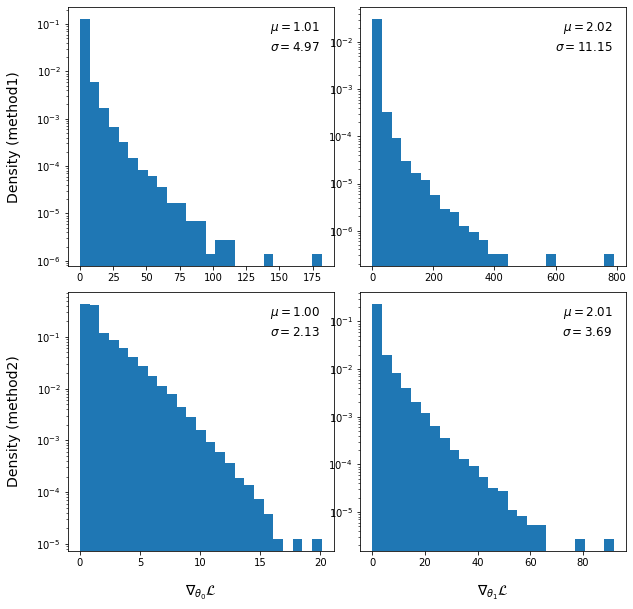

In [6]:
#  Randomly sample N datapoints and compute the contributions to the estimators using method1 and method2
#  Plot these as histograms

u = np.random.normal(size=(N,))
x = theta0 + theta1*u
grad_estimates_method0 = method1(x, theta0, theta1)
grad_estimates_method1 = method2(u, theta0, theta1)

plot_grad_estimate_scatter(theta0, theta1, N, u, x, grad_estimates_method0, grad_estimates_method1)

**We find that method 2 is less sharply peaked towards zero, and has a smaller tail, allowing us to estimate the mean with less variance**

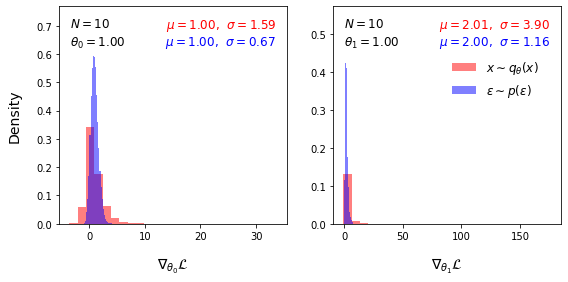

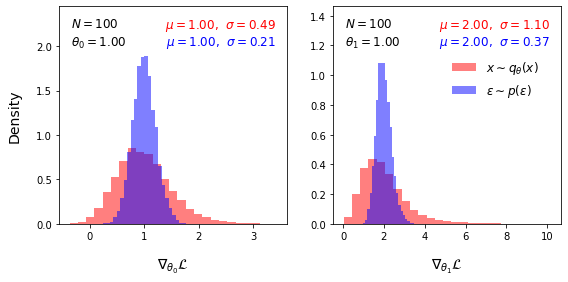

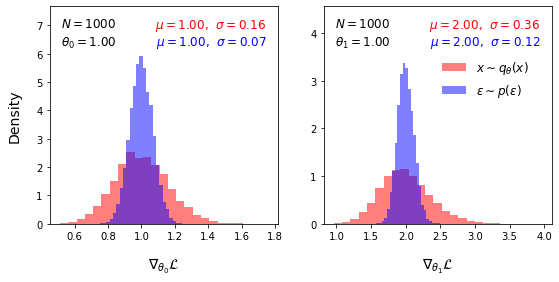

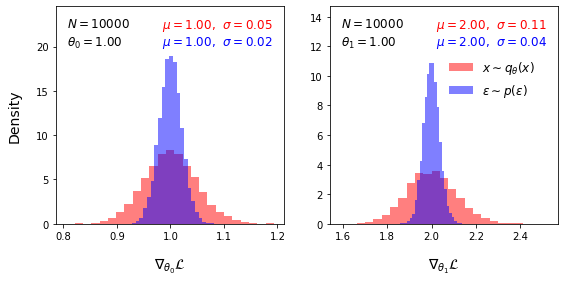

In [7]:
#  For a variety of different numbers of samples N, compute the gradient estimators in a large number of toys
#  Histogram these to see how the means and variances compare

num_trials = 10000

Ns = [10, 100, 1000, 10000]

for N in Ns :
    theta_grad_estimates_method0, theta_grad_estimates_method1 = [], []

    for trial_idx in range(num_trials) :
        u = np.random.normal(size=(N,))
        x = theta0 + theta1*u
        theta_grad_estimates_method0.append(np.mean(method1(x, theta0, theta1), axis=0))
        theta_grad_estimates_method1.append(np.mean(method2(u, theta0, theta1), axis=0))

    theta_grad_estimates_method0 = np.array(theta_grad_estimates_method0)
    theta_grad_estimates_method1 = np.array(theta_grad_estimates_method1)
    
    plot_grad_estimates  (theta0, theta1, N, theta_grad_estimates_method0, theta_grad_estimates_method1)


**For all values of N, we find that both estimators agree well on the mean estimated gradient, but the method 2 has significantly lower variance**

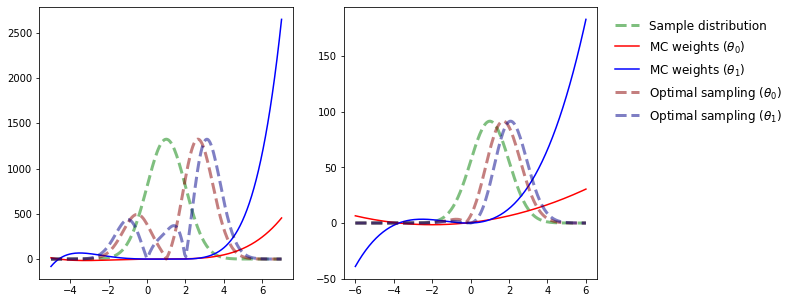

In [36]:
#  Study how MC weights, true sampling distribution and optimal sampling distributions compare

x             = np.linspace(theta0 - 6*theta1, theta0+6*theta1, 201)
grad_x_theta  = method1 (x, theta0, theta1)
prob_x        = stats.norm.pdf(x, scale=theta0, loc=theta1)
grad_x_prob_x = np.fabs(np.array([prob_x*grad_x_theta[:,0], prob_x*grad_x_theta[:,1]]).transpose())

e             = np.linspace(-6, 6, 201)
grad_e_theta  = method2 (e, theta0, theta1)
prob_e        = stats.norm.pdf(e, scale=theta0, loc=theta1)
grad_x_prob_e = np.fabs(np.array([prob_e*grad_e_theta[:,0], prob_e*grad_e_theta[:,1]]).transpose())

fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(1, 2, 1)
ax.plot(x, 0.5*prob_x*np.max(grad_x_theta)/np.max(prob_x), "--", c="g", alpha=0.5, lw=3)
ax.plot(x, grad_x_theta[:,0], "-", c="r")
ax.plot(x, grad_x_theta[:,1], "-", c="b")
ax.plot(x, 0.5*grad_x_prob_x[:,0]*np.max(grad_x_theta)/np.max(grad_x_prob_x[:,0]), "--", c="darkred" , alpha=0.5, lw=3)
ax.plot(x, 0.5*grad_x_prob_x[:,1]*np.max(grad_x_theta)/np.max(grad_x_prob_x[:,1]), "--", c="darkblue", alpha=0.5, lw=3)

ax  = fig.add_subplot(1, 2, 2)
ax.plot(e, 0.5*prob_e*np.max(grad_e_theta)/np.max(prob_e), "--", c="g", alpha=0.5, lw=3, label="Sample distribution")
ax.plot(e, grad_e_theta[:,0], "-", c="r", label=r"MC weights ($\theta_0$)")
ax.plot(e, grad_e_theta[:,1], "-", c="b", label=r"MC weights ($\theta_1$)")
ax.plot(e, 0.5*grad_x_prob_e[:,0]*np.max(grad_e_theta)/np.max(grad_x_prob_e[:,0]), "--", c="darkred" , alpha=0.5, lw=3, label=r"Optimal sampling ($\theta_0$)")
ax.plot(e, 0.5*grad_x_prob_e[:,1]*np.max(grad_e_theta)/np.max(grad_x_prob_e[:,1]), "--", c="darkblue", alpha=0.5, lw=3, label=r"Optimal sampling ($\theta_1$)")

ax.legend(loc=(1.05, 0.55), frameon=False, fontsize=12)

plt.show()